In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
import sklearn
plt.style.use('seaborn')
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [34]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_localize('UTC')
None

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [35]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
None

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [79]:
df = strava.join(cheetah,how='inner').dropna()
#only keep intresting columns mentioned before and remove no watt records
df = df[(df['Average Cadence']!= 0) & (df['device_watts'] == True)][['time','average_heartrate','average_temp','average_watts','device_watts','distance','elapsed_time','elevation_gain','kudos','moving_time','workout_type','Average Speed','Nonzero Average Power','Average Cadence','VAM','Calories (HR)','1 sec Peak Power','1 min Peak Hr','NP','TSS']]
df['elevation_gain'],df['time_hour'] = df['elevation_gain'].map(lambda x : float(x.replace(" m",''))),(pd.to_timedelta(df['time'],unit='m')).astype('timedelta64[m]')/60

## Cleaning

here i have cleaned the data, after inspecting the data later on in my analysis i realized there are quite a few feilds with data stacking up at 0 (or in the case of the temp reading from cheetah -255) i opted to prune these out of the data as they worsened my regression errors and dont seem to be real observations but instead missing values.

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


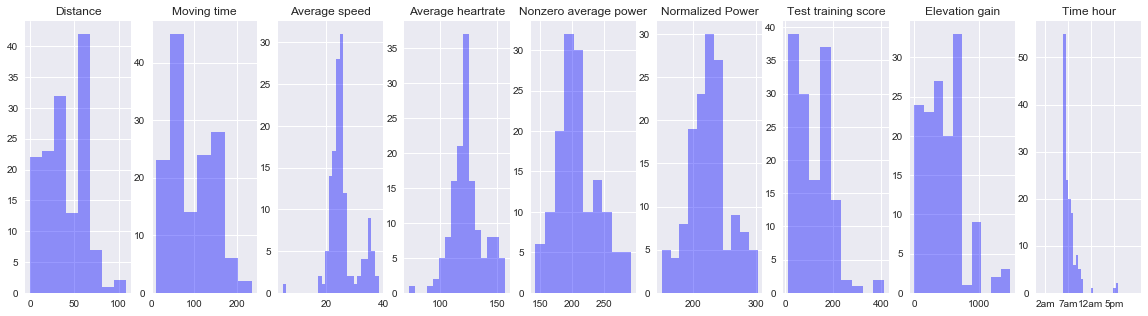

In [138]:
feilds = ['distance','moving_time','Average Speed','average_heartrate', 'Nonzero Average Power','NP', 'TSS','elevation_gain']
def beautifyName(name,newLine=False):
    res = ''
    if(name == 'NP'):
        res = 'Normalized Power'
    elif (name == 'TSS'):
        res = 'Test training score'
    else:
        res = name.replace("_"," ").capitalize()
    return res.replace(' ','\n') if newLine else res

fig, axArr = plt.subplots(1,len(feilds)+1,figsize=(20,5))
for key,ax in zip(feilds,axArr[:len(feilds)]):
    sns.distplot(df[key],kde=False,color=sns.saturate('b'),ax=ax).set_title(beautifyName(key))
    ax.set_xlabel(None)
    
sns.distplot(df['time_hour'],kde=False,ax=axArr[len(feilds)],color=sns.saturate('b')).set_title(beautifyName('time_hour'))
axArr[len(feilds)].set_xlabel(None),plt.xlim(0,23),plt.xticks([2,7,12,17],['2am','7am','12am','5pm'])
None

# Distribution of data  


## Zero Stacking
**Distance, Moving time, Test training score, Elevation gain and Time hour**
all seem to be stacked at 0.

## Non-normal Distrubutions
**Elevation gain and Test traing score** both do not seem to be normally distributed and **Normalized power, Moving time, Distance and Time hour** may well be non normall aswell but the case is weaker.

## Normal Distributions
**Average speed, Average heartrate and NZ Average power** all seem to be aproximatley normal however it is worth noting **average speed** seems bi-modal.


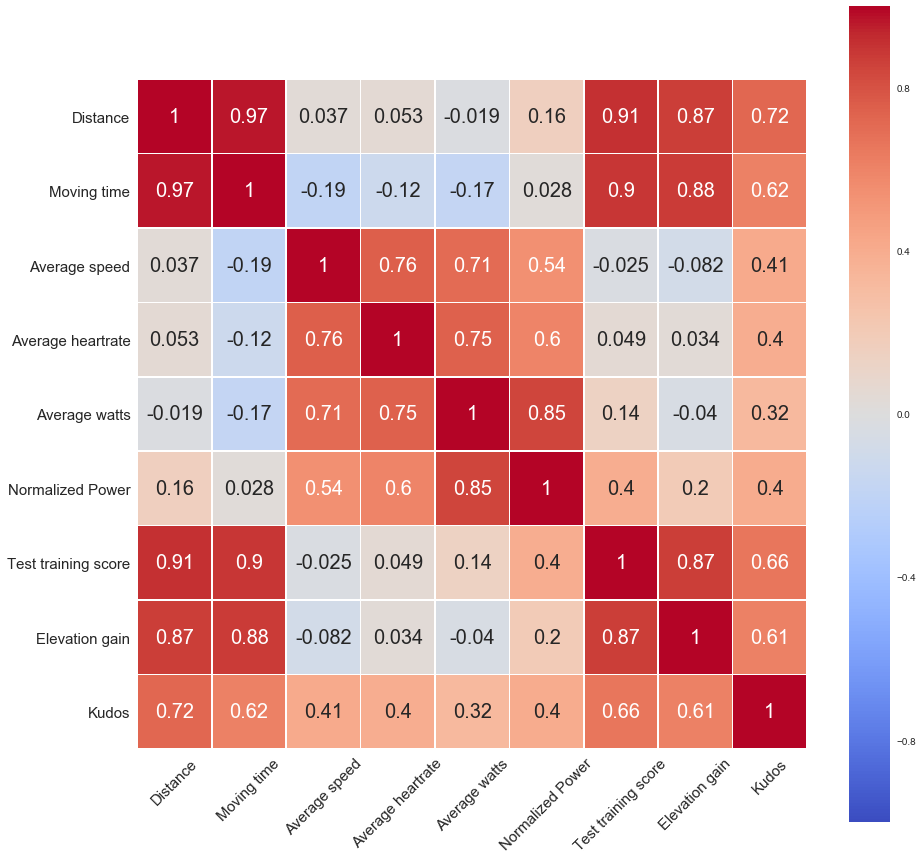

In [142]:
from matplotlib import colors as cols
corelCols = ['distance','moving_time','Average Speed','average_heartrate','average_watts','NP','TSS','elevation_gain','kudos']
correl = df[corelCols].corr()
fig, ax = plt.subplots(figsize=(15,15))
ax.tick_params(which='both', labelsize=15)
sns.heatmap(correl,ax=ax, cmap='coolwarm',square=True, annot=True, annot_kws={"size": 20},linewidths=.5,center=0, vmin=-1, vmax=1)
ax.set_xticklabels([beautifyName(e) for e in corelCols],rotation=45),ax.set_yticklabels([beautifyName(e) for e in corelCols])
None

# Correlation
<br/>

above is a "corelation" matrix.

simply white squares represent no correlation, red represent positive and blue negative, the stronger the colour the stronger the correlation

this is done via [linear regression](https://en.wikipedia.org/wiki/Linear_regression) <br/><br/>

note the strong red on the diagonals is only there as "somevalue" will allways correlate 1:1 with itself

typicaly .25 is considerd a weak correaltion .5 moderate and .75 verry strong

it is importnant to note that some of these correaltions may be trivial observations or tell us verry little

One thing that initally stands out is **Distance** and **Moving time** have a near perfect correaltion but this makes sense if the rider takes similar routes and/or rides at the same speed consitently and and a result the correaltions for these 2 rows are almost identical for all other variables

Other than that there are a hand full of red squares that all show clusters of variables that all have correlations woith one another and it is worth noting all of the negative correlations (showin in blue) are all quite weak.

In [63]:
import numpy as np
def getRowCorrel(key):
    fig, ax = plt.subplots(figsize=(20,20))
    row = pd.DataFrame([correl[key]]).drop(key,axis='columns')
    mat = ax.matshow(row,cmap='coolwarm', norm =cols.Normalize(-1,1))
    plt.xticks(range(row.shape[1]), [beautifyName(e) for e in row.columns.values], fontsize=20, rotation=45)
    plt.grid(b=None)
    plt.yticks([])
    plt.ylabel(beautifyName(key,True),fontsize=20,rotation=0,labelpad=50)
    for (i, j), z in np.ndenumerate(row):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize =20)
    plt.show()

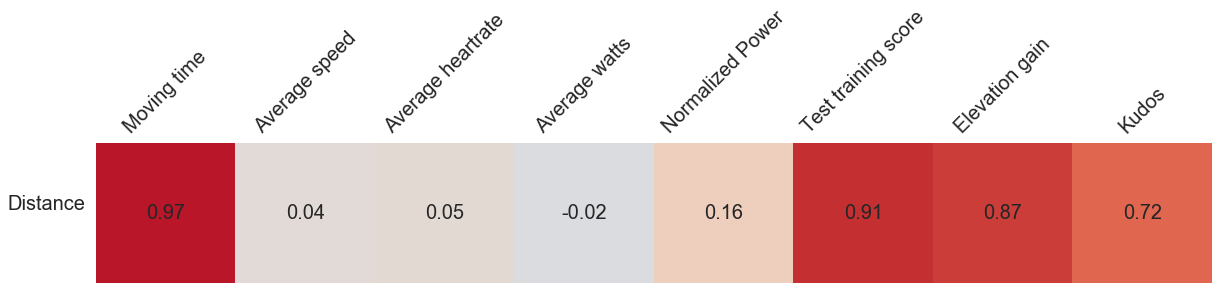

In [60]:
getRowCorrel('distance')

## Distance

here we can see distance has a strong correlaton with moving time and elapsed time (to be expected)

aswell as a strong correlation with kudos witch is a much more intresting observation as it isnt obviously dependant on time

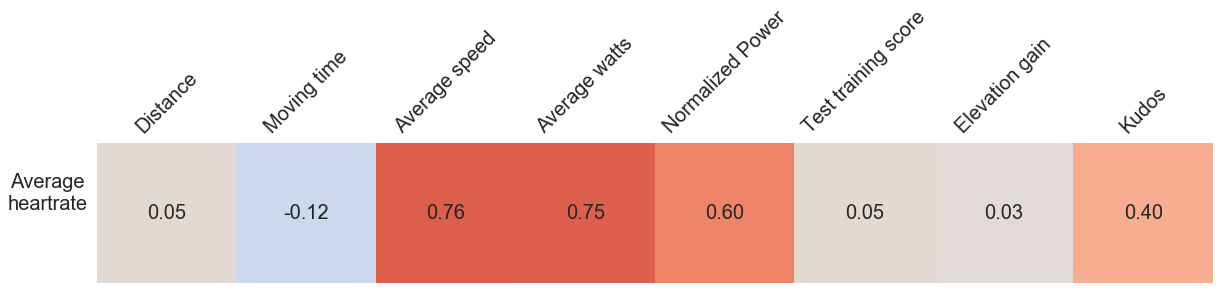

In [64]:
getRowCorrel('average_heartrate')

## Heart rate

Heartrate has a moderate correlation with average watts aswell as a weaker one with kudos

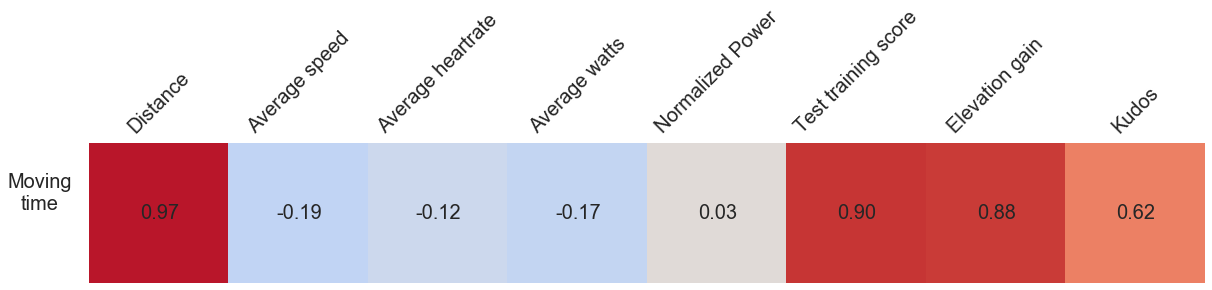

In [65]:
getRowCorrel('moving_time')

## Moving time

moving time has a strong correlation with **Distance** and **Elapsed Time**

more intrestingly it has a correlation with **Kudos** however it is not as strong 

additionally it has some weak negative corelations with **Average (Speed/HeartRate/Watts)**

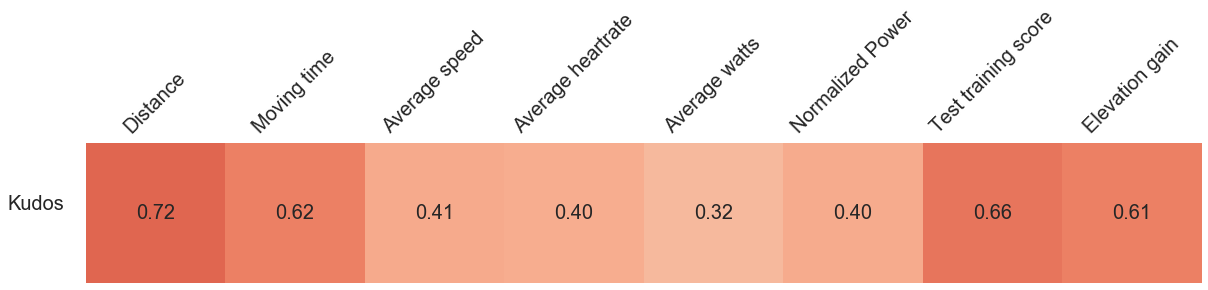

In [66]:
getRowCorrel('kudos')

## Kudos

Intestingly Kudos has a moderate to strong positive correlaion with almost all of the variables the strongest being **Distance** and weakest being **Average Watts**

## Workout Types

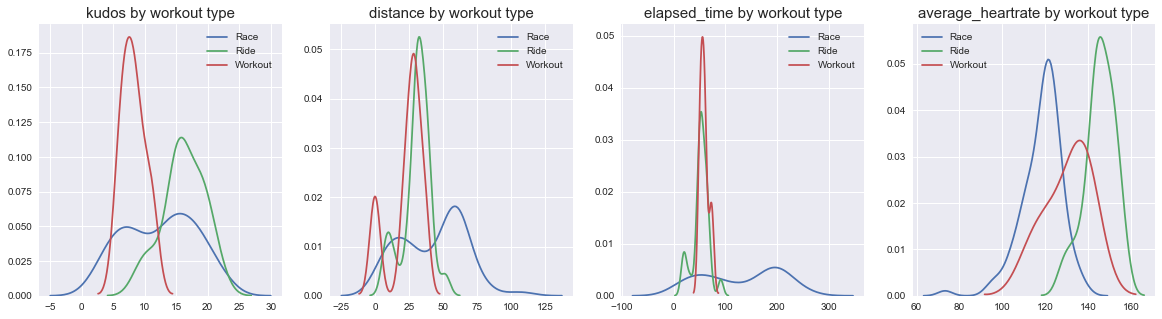

In [82]:
ride,race,workout = df[df['workout_type'] == 'Ride'],df[df['workout_type'] == 'Race'],df[df['workout_type'] == 'Workout']
workoutGroups,names = [ride,race,workout], ['Race','Ride','Workout']

def plotMulti(subSets,names,feild,ax=None):
    for item,name in zip(subSets,names):
        sns.kdeplot(item[feild],label=name,ax=ax)
    ax.set_title(f"{feild} by workout type",fontsize=15)

fig, axArr = plt.subplots(1,4,figsize=(20,5))
plotMulti(workoutGroups,names,'kudos',axArr[0])
plotMulti(workoutGroups,names,'distance',axArr[1])
plotMulti(workoutGroups,names,'elapsed_time',axArr[2])
plotMulti(workoutGroups,names,'average_heartrate',axArr[3])
None

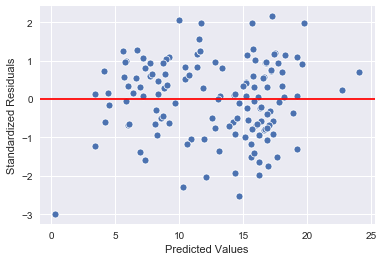

 Mean Squared Error: 8.45613162774559
 Root Mean Squared Error: 2.907942851526761
 Colums Kept:
  Average temp
  Distance
  Elapsed time
  Moving time
  Average speed
  Nonzero average power
  Average cadence
  Time hour


In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import math
#its worth noting i am traning and testing on the same data here

estimator = sklearn.linear_model.LinearRegression()
predictors = df[[x for x in df._get_numeric_data().columns.values if x != 'kudos']]
selector = sklearn.feature_selection.RFE(estimator,step=1)
selector = selector.fit(predictors,df['kudos'])

predicted = selector.predict(predictors)
residuals = predicted -df['kudos']
mse =  (residuals  ** 2).sum()/len(residuals)
rmse = math.sqrt(mse)
supportCols,prunedCols = predictors.columns.values[selector.support_],predictors.columns.values[~selector.support_]

residualScaler = StandardScaler()
residualScaler = residualScaler.fit(pd.DataFrame({'data':residuals}))
sns.scatterplot(predicted,residualScaler.transform([residuals])[0])
plt.ylabel("Standardized Residuals")
plt.xlabel("Predicted Values")
plt.title = 'Residual Plot'
plt.axhline(color='r')
plt.show()
nl = '\n  '
print(f' Mean Squared Error: {mse}\n',
      f'Root Mean Squared Error: {rmse}\n',
      f"Colums Kept:{nl}{nl.join(beautifyName(e) for e in supportCols)}")

In [11]:
#kept = sns.pairplot(df,x_vars=supportCols,y_vars='kudos',kind='reg').fig.suptitle("Kept Predictors",size=30,y=1.15)
#pruned = sns.pairplot(df,x_vars=prunedCols,y_vars='kudos',kind='reg').fig.suptitle("Pruned Predictors",size=35,y=1.15)
#None
df.columns.values
labels = ["hi-myname","jee-ff"]
nl = "\n"
l2 = [e.replace("-","\n") for e in labels]

for e in l2:
    print(e)
    print("---")

hi
myname
---
jee
ff
---


## Kudos
#### bonus question

Here i opted to use a linear regression model with RFE to prune predictors that had a poor predictive value
it yelded a model that had a  Mean Squared Error of 8.4 and a Root Mean Squared Error of 2.9

for this i also included the scatter plots so one can eyball if the correlations seem to make sense one that stands out is **Time hour** as it seems that the correlation has been fit incorectly and at the verry least a worse fit than say **Calories** however it may be the case that in the higer dementional space it helps reduce over or under prediction that other feilds introduce